# Кластеризація отриманих результатів

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
from kneed import KneeLocator

In [171]:
!pip install kneed

In [96]:
!pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805913 sha256=3c488076283e5d4f28ebba10cbdbc6d965eb92932bed3b0af6a7f878adaa9b86
  Stored in directory: c:\users\lidao\appdata\local\pip\cache\wheels\23\f6\d3\110e53bd43baeb8d7d38049733d48e39cbecd056f01dba7ee8
Successfully built pyspark


## Підготовка даних для кластеризації

In [3]:
#Бібліотеки для побудови графіків 
from pyspark.ml.feature import VectorAssembler
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification, make_regression
import pandas as pd
import numpy as np
import argparse
import json
import re
import os
import sys

In [4]:
df = pd.read_spss('Data_prodjWork_copy.sav')

In [5]:
feature_cols = ['Estimate_positive', 'Estimate_negative',
       'Probabipity_negative', 'Probabipity_positive']
X = df[feature_cols] # незалежні змінні
y = df['SEO_ALL_GROUP'] # залежна змінна

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
df = pd.DataFrame(X_scaled)

In [10]:
df.describe()

,0,1,2,3
count,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.091734,0.032373,0.019752,0.031822
std,0.077625,0.063296,0.044751,0.041315
min,0.000000,0.000000,0.000000,0.000000
25%,0.074506,0.012839,0.008806,0.023529
50%,0.091562,0.024225,0.015166,0.029739
75%,0.101436,0.041667,0.024951,0.034641
max,1.000000,1.000000,1.000000,1.000000


## Кластеризація методом К середніх

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state = 123).fit(X)

In [13]:
from sklearn.metrics import silhouette_score

In [15]:
scaled_features = X

In [16]:
kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(2)

In [17]:
kmeans_silhouette

0.94

In [38]:
kmeans.n_iter_

2

In [18]:
kmeans.inertia_

16536042.353083085

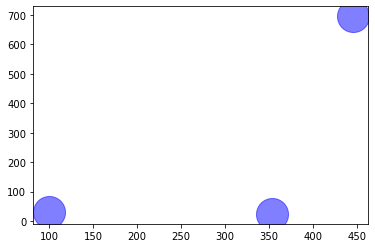

In [27]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=1030, alpha=0.5);
plt.savefig("mlpr_0107.png", dpi = 300,  bbox_inches="tight")

## Якісні показники кластерного аналізу 

In [21]:
 df['cluster'] = kmeans.labels_

In [22]:
df.groupby(['cluster'])[0].sum() #Позитивна оцінка

cluster
0    90.749551
1     1.198384
2     2.537702
Name: 0, dtype: float64

In [23]:
df.groupby(['cluster'])[0].count() 

cluster
0    1019
1       3
2       8
Name: 0, dtype: int64

In [24]:
df.groupby(['cluster'])[1].sum() #Негативна оцінка

cluster
0    31.134690
1     2.023256
2     0.186047
Name: 1, dtype: float64

In [25]:
df.groupby(['cluster'])[3].sum() #Низька ймовірність

cluster
0    29.177124
1     0.102614
2     3.497386
Name: 3, dtype: float64

In [26]:
df.groupby(['cluster'])[2].sum() #Висока ймовірність

cluster
0    17.047456
1     2.011742
2     1.285714
Name: 2, dtype: float64

### Графічна побудова кривої, котра підтверджує яку кількість кластерів варто вибрати

In [29]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}


In [30]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

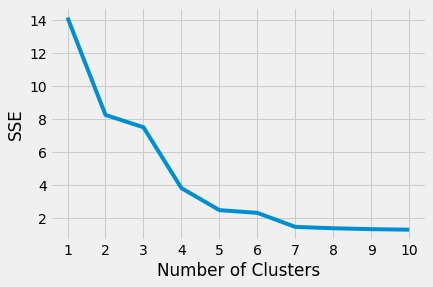

<Figure size 432x288 with 0 Axes>

In [31]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
plt.savefig("mlpr_0108.png", dpi = 300,  bbox_inches="tight")

## Кластеризація методом DBSCAN

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [33]:
scaled_features = X

In [45]:
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=0.5)

dbscan.fit(scaled_features)


dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round (2)

In [46]:
dbscan_silhouette

0.93

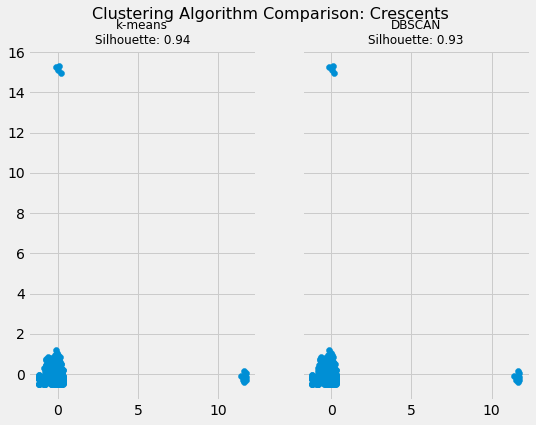

<Figure size 432x288 with 0 Axes>

In [47]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
fig, (ax1, ax2) = plt.subplots (
    1, 2, figsize=(8, 6), sharex=True, sharey=True
                               )

fig.suptitle( 
             f"Clustering Algorithm Comparison: Crescents", fontsize=16
             )
fte_colors = {
    0: "#008fd5", 
    1: "#fc4f30",
             }
# The k-means plot

#km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter (scaled_features[:, 0], scaled_features[:, 1])

ax1.set_title(
              f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12}
             )

#db_colors =[fte_colors[label] for label in dbscan.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1])

ax2.set_title(
              f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
             )
plt.show()
plt.savefig("mlpr_0108.png", dpi = 300,  bbox_inches="tight")

## Їєрархічна кластеризація

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [39]:
hc_complete = linkage(X, "complete")

In [40]:
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

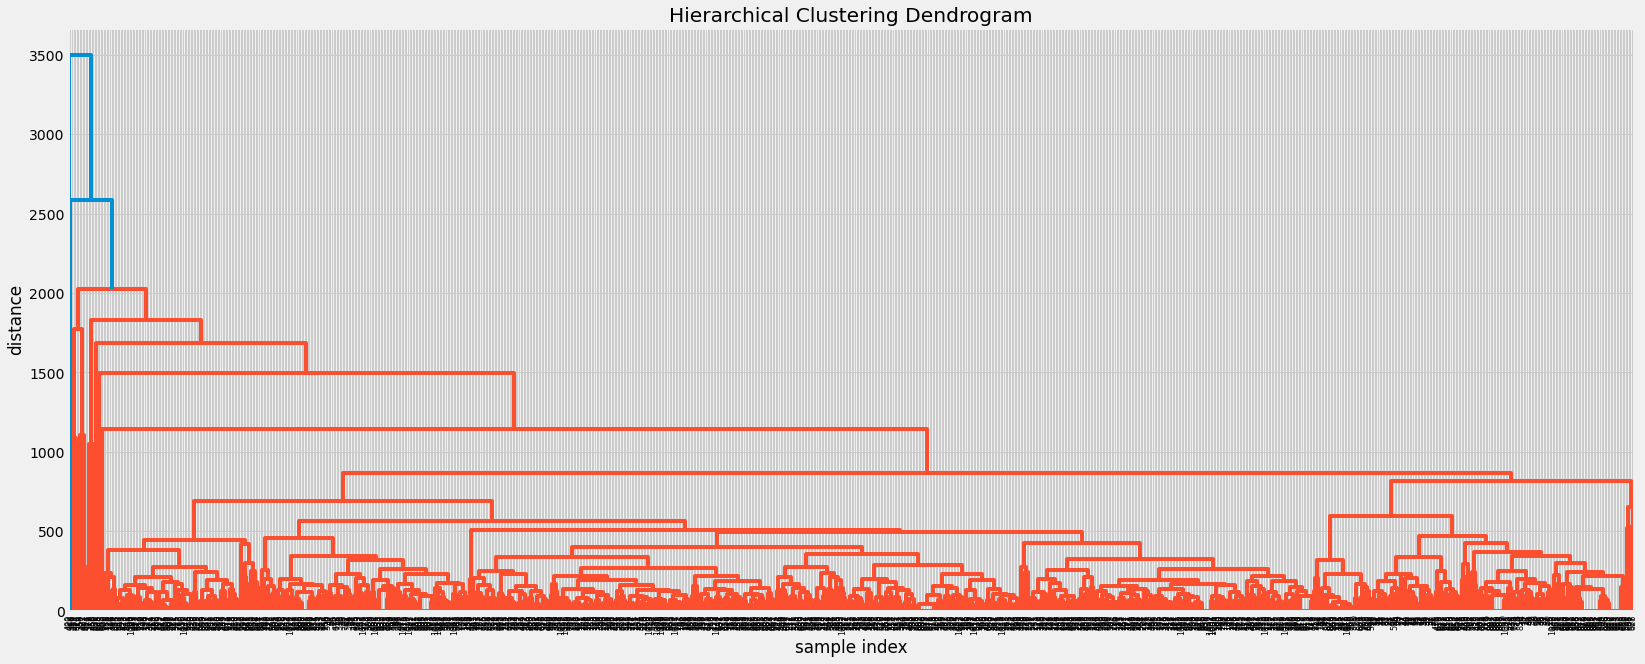

In [79]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    hc_complete, p = 5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

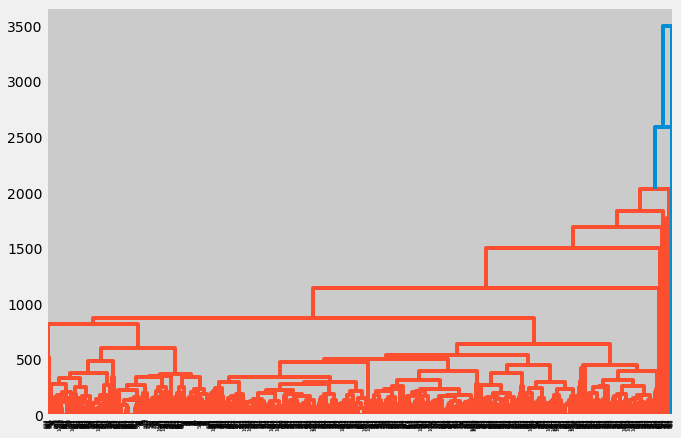

In [228]:
plt.figure(figsize = (10, 7))
dendrogram( hc_complete, p=5,  orientation = 'top', distance_sort ='descending',show_leaf_counts = True)
plt.show()